In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import logging
import datetime

In [5]:
def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def predict_chunk(df_, clfs_, meta_, features, train_mean):

    df_['flux_ratio_sq'] = np.power(df_['flux'] / df_['flux_err'], 2.0)
    df_['flux_by_flux_ratio_sq'] = df_['flux'] * df_['flux_ratio_sq']

    # Group by object id
    aggs = get_aggregations()

    aggs = get_aggregations()
    aggs['flux_ratio_sq'] = ['sum']
    aggs['flux_by_flux_ratio_sq'] = ['sum']

    new_columns = get_new_columns(aggs)

    agg_ = df_.groupby('object_id').agg(aggs)
    agg_.columns = new_columns

    agg_ = add_features_to_agg(df=agg_)

    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )

    full_test = full_test.fillna(train_mean)
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

    print(preds_df_['class_99'].mean())

    del agg_, full_test, preds_
    gc.collect()

    return preds_df_


def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 24))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig(r'../feat/importances_{}.png'.format(datetime.datetime.now().strftime('%m%d_%H%M')))
    importances_.sort_values('mean_gain', ascending=False).to_csv(r'../feat/feat_rank_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)


def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3
    }
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

    return clfs, importances


def get_aggregations():
    return {
        'mjd': ['min', 'max', 'size'],
        'passband': ['mean', 'std', 'var'],  # ''min', 'max', 'mean', 'median', 'std'],
#         'flux': ['min', 'max', 'mean', 'median', 'std'],
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std'],
        'detected': ['mean'],  # ''min', 'max', 'mean', 'median', 'std'],
    }


def get_new_columns(aggs):
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]


def add_features_to_agg(df):
    df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
    df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
    df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']



    del df['mjd_max'], df['mjd_min']

    return df

In [19]:
train = pd.read_csv('../data/training_set.csv')
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [ ]:
flux_mean = db.groupby(['object_id','passband'])['flux'].mean().unstack()
flux_mean['object_id'] = flux_mean.index
flux_mean.reset_index(drop=True, inplace=True)

In [45]:
meta_train = pd.read_csv('../data/training_set_metadata.csv')
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [46]:
train.passband.describe()

count    1.421705e+06
mean     2.783108e+00
std      1.703946e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: passband, dtype: float64

In [1]:
# band = train.groupby(['object_id','passband'])['flux'].mean().unstack()
# band['object_id'] = band.index
# band.reset_index(drop=True, inplace=True)
# band

In [25]:
meta_train[meta_train.distmod.isnull()]['mwebv'].describe()

count    2325.000000
mean        0.141224
std         0.227477
min         0.004000
25%         0.020000
50%         0.055000
75%         0.146000
max         2.747000
Name: mwebv, dtype: float64

In [27]:
meta_train[meta_train.distmod.notnull()]['distmod'].describe()

count    5523.000000
mean       41.263961
std         2.262711
min        31.996100
25%        39.845250
50%        41.167900
75%        42.398550
max        47.025600
Name: distmod, dtype: float64

In [28]:
meta_train['distmod'].describe()

count    5523.000000
mean       41.263961
std         2.262711
min        31.996100
25%        39.845250
50%        41.167900
75%        42.398550
max        47.025600
Name: distmod, dtype: float64

In [21]:
def add_band_feats(df, db):
    
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    # band_#_flux_min互相做差
    min_cols = stats.columns.tolist()
    for col in min_cols:
        subtract_cols = [col_ for col_ in min_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['band_' + str(band_n) + '_flux_diff1'] = df['band_' + str(band_n) + '_flux_max'] - df['band_' + str(band_n) + '_flux_min']
        df['band_' + str(band_n) + '_flux_diff2'] = df['band_' + str(band_n) + '_flux_diff1']/df['band_' + str(band_n) + '_flux_mean']
        print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    
    return df

    
#     print('Adding feats for the flux mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
#     stats['object_id'] = stats.index
#     stats.columns = [str(col) + '_mean' for col in stats.columns.tolist()]
#     df = df.merge(db, on='object_id', how='left').fillna(0)
#     print('Feats added:',stats.columns.tolist())
    
    
    

In [22]:
def main():
    train = pd.read_csv('../input/training_set.csv')
    train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
    train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']
    
#     # 增加正负1sigma
#     train['flux_m_err'] = train['flux'] - train['flux_err'] 
#     train['flux_p_err'] = train['flux'] + train['flux_err'] 
#     # 增加正负1sigma

    # train = pd.concat([train, pd.get_dummies(train['passband'], prefix='passband')], axis=1, sort=False)

    aggs = get_aggregations()
    aggs['flux_ratio_sq'] = ['sum']
    aggs['flux_by_flux_ratio_sq'] = ['sum']

    
#     # 增加正负1sigma    
#     aggs['flux_m_err'] = ['sum']
#     aggs['flux_p_err'] = ['sum']
    
#     aggs['flux_m_err'] = ['mean']
#     aggs['flux_p_err'] = ['mean']
#     # 增加正负1sigma
    
    
    # passbands = [f for f in train if 'passband_' in f]
    # get_logger().info('Passband features : {}'.format(passbands))
    # for pb in passbands:
    #     aggs[pb] = ['mean']

    agg_train = train.groupby('object_id').agg(aggs)
    new_columns = get_new_columns(aggs)
    agg_train.columns = new_columns

    agg_train = add_features_to_agg(df=agg_train)
    
    agg_train.head()

#     del train
#     gc.collect()

    meta_train = pd.read_csv('../input/training_set_metadata.csv')
    meta_train.head()
    
    # 增加是否在银河系的特征
#     distmod_min = meta_train.distmod.min()
#     meta_train.distmod.fillna(distmod_min,inplace=True)
#     meta_train['in_MilkyWay'] = 0
#     meta_train[meta_train.in_MilkyWay == 1]
    # 增加是否在银河系的特征

    full_train = agg_train.reset_index().merge(
        right=meta_train,
        how='outer',
        on='object_id'
    )
    
    

    y = full_train['target']
    del full_train['target']
#     del full_train['object_id'], full_train['hostgal_specz']  # , full_train['distmod']
    del full_train['hostgal_specz']  # , full_train['distmod']

    train_mean = full_train.mean(axis=0)
    full_train.fillna(train_mean, inplace=True)
    
    # 增加 mean_flux_per_band
#     band = train.groupby(['object_id','passband'])['flux'].mean().unstack()
#     band['object_id'] = band.index
#     band.reset_index(drop=True, inplace=True)
#     full_train = full_train.merge(band, on='object_id', how='left').fillna(0)
    
    full_train = add_band_feats(full_train, train)
    

    # 增加 mean_flux_per_band
    
    
    
    
    
    
    
    
    del full_train['object_id']
        
    del train
    gc.collect()

        
    get_logger().info(full_train.columns)
    clfs, importances = train_classifiers(full_train, y)

    save_importances(importances_=importances)

#     meta_test = pd.read_csv('../input/test_set_metadata.csv')

#     import time

#     start = time.time()
#     chunks = 5000000
#     remain_df = None

#     for i_c, df in enumerate(pd.read_csv('../input/test_set.csv', chunksize=chunks, iterator=True)):
#         # Check object_ids
#         # I believe np.unique keeps the order of group_ids as they appear in the file
#         unique_ids = np.unique(df['object_id'])
#         new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()

#         if remain_df is None:
#             df = df.loc[df['object_id'].isin(unique_ids[:-1])].copy()
#         else:
#             df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)

#         # Create remaining samples df
#         remain_df = new_remain_df

#         preds_df = predict_chunk(df_=df,
#                                  clfs_=clfs,
#                                  meta_=meta_test,
#                                  features=full_train.columns,
#                                  train_mean=train_mean)

#         if i_c == 0:
#             preds_df.to_csv('predictions_v3.csv', header=True, index=False, float_format='%.6f')
#         else:
#             preds_df.to_csv('predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

#         del preds_df
#         gc.collect()

#         if (i_c + 1) % 10 == 0:
#             get_logger().info('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
#             print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

#     # Compute last object in remain_df

#     preds_df = predict_chunk(df_=remain_df,
#                              clfs_=clfs,
#                              meta_=meta_test,
#                              features=full_train.columns,
#                              train_mean=train_mean)

#     preds_df.to_csv('predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

#     z = pd.read_csv('predictions_v3.csv')

#     z = z.groupby('object_id').mean()

#     z.to_csv('single_predictions_v3.csv', index=True, float_format='%.6f')




Adding feats for the flux mean per band...
Feats added: ['band_0_flux_mean', 'band_1_flux_mean', 'band_2_flux_mean', 'band_3_flux_mean', 'band_4_flux_mean', 'band_5_flux_mean', 'band_1_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_0_flux_mean', 'band_2_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_0_flux_mean', 'band_3_flux_mean_minus_band_1_flux_mean', 'band_3_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_0_flux_mean', 'band_4_flux_mean_minus_band_1_flux_mean', 'band_4_flux_mean_minus_band_2_flux_mean', 'band_4_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_0_flux_mean', 'band_5_flux_mean_minus_band_1_flux_mean', 'band_5_flux_mean_minus_band_2_flux_mean', 'band_5_flux_mean_minus_band_3_flux_mean', 'band_5_flux_mean_minus_band_4_flux_mean']
Adding feats for the flux std per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_std', 'band_1_flux_std', 'band_2_flux_std', 'band_3_flux_std', 'band_4_flux_std', 'band_5_flux_std']
Adding feats for the flux skew per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_skew', 'band_1_flux_skew', 'band_2_flux_skew', 'band_3_flux_skew', 'band_4_flux_skew', 'band_5_flux_skew']
Adding feats for the flux max per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_max', 'band_1_flux_max', 'band_2_flux_max', 'band_3_flux_max', 'band_4_flux_max', 'band_5_flux_max', 'band_1_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_0_flux_max', 'band_2_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_0_flux_max', 'band_3_flux_max_minus_band_1_flux_max', 'band_3_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_0_flux_max', 'band_4_flux_max_minus_band_1_flux_max', 'band_4_flux_max_minus_band_2_flux_max', 'band_4_flux_max_minus_band_3_flux_max', 'band_5_flux_max_minus_band_0_flux_max', 'band_5_flux_max_minus_band_1_flux_max', 'band_5_flux_max_minus_band_2_flux_max', 'band_5_flux_max_minus_band_3_flux_max', 'band_5_flux_max_minus_band_4_flux_max']
Adding feats for the flux min per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Feats added: ['band_0_flux_min', 'band_1_flux_min', 'band_2_flux_min', 'band_3_flux_min', 'band_4_flux_min', 'band_5_flux_min', 'band_1_flux_min_minus_band_0_flux_min', 'band_2_flux_min_minus_band_0_flux_min', 'band_2_flux_min_minus_band_1_flux_min', 'band_3_flux_min_minus_band_0_flux_min', 'band_3_flux_min_minus_band_1_flux_min', 'band_3_flux_min_minus_band_2_flux_min', 'band_4_flux_min_minus_band_0_flux_min', 'band_4_flux_min_minus_band_1_flux_min', 'band_4_flux_min_minus_band_2_flux_min', 'band_4_flux_min_minus_band_3_flux_min', 'band_5_flux_min_minus_band_0_flux_min', 'band_5_flux_min_minus_band_1_flux_min', 'band_5_flux_min_minus_band_2_flux_min', 'band_5_flux_min_minus_band_3_flux_min', 'band_5_flux_min_minus_band_4_flux_min']
Adding feats for the flux_err mean per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
[INFO]2018-10-25 18:54:44,659:main:Index(['mjd_size', 'passband_mean', 'passband_std', 'passband_var', 'flux_min',
       'flux_max', 'flux_mean', 'flux_median', 'flux_std', 'flux_skew',
       ...
       'band_2_flux_err_ratio', 'band_3_flux_diff1', 'band_3_flux_diff2',
       'band_3_flux_err_ratio', 'band_4_flux_diff1', 'band_4_flux_diff2',
       'band_4_flux_err_ratio', 'band_5_flux_diff1', 'band_5_flux_diff2',
       'band_5_flux_err_ratio'],
      dtype='object', length=131)
[INFO]2018-10-25 18:54:44,659:main:Index(['mjd_

Feats added: ['band_0_flux_err_mean', 'band_1_flux_err_mean', 'band_2_flux_err_mean', 'band_3_flux_err_mean', 'band_4_flux_err_mean', 'band_5_flux_err_mean']
Adding feats for the flux (max-min)/mean per band...
Feature added: band_0_flux_diff2
Feature added: band_0_flux_err_ratio
Feature added: band_1_flux_diff2
Feature added: band_1_flux_err_ratio
Feature added: band_2_flux_diff2
Feature added: band_2_flux_err_ratio
Feature added: band_3_flux_diff2
Feature added: band_3_flux_err_ratio
Feature added: band_4_flux_diff2
Feature added: band_4_flux_err_ratio
Feature added: band_5_flux_diff2
Feature added: band_5_flux_err_ratio
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.78721	training's wloss: 1.01446	valid_1's multi_logloss: 0.863812	valid_1's wloss: 1.19175
[200]	training's multi_logloss: 0.567417	training's wloss: 0.731791	valid_1's multi_logloss: 0.693449	valid_1's wloss: 1.01053
[300]	training's multi_logloss: 0.473529	training's wlo

[INFO]2018-10-25 18:55:06,207:main:0.9236799264374469
[INFO]2018-10-25 18:55:06,207:main:0.9236799264374469
[INFO]2018-10-25 18:55:06,207:main:0.9236799264374469
[INFO]2018-10-25 18:55:06,207:main:0.9236799264374469
[INFO]2018-10-25 18:55:06,207:main:0.9236799264374469
[INFO]2018-10-25 18:55:06,207:main:0.9236799264374469


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.783603	training's wloss: 0.99807	valid_1's multi_logloss: 0.868196	valid_1's wloss: 1.19404
[200]	training's multi_logloss: 0.563003	training's wloss: 0.713992	valid_1's multi_logloss: 0.702416	valid_1's wloss: 1.01908
[300]	training's multi_logloss: 0.468381	training's wloss: 0.56573	valid_1's multi_logloss: 0.658011	valid_1's wloss: 0.967872
Early stopping, best iteration is:
[338]	training's multi_logloss: 0.44269	training's wloss: 0.525537	valid_1's multi_logloss: 0.650485	valid_1's wloss: 0.963051


[INFO]2018-10-25 18:55:20,340:main:0.9630506895043018
[INFO]2018-10-25 18:55:20,340:main:0.9630506895043018
[INFO]2018-10-25 18:55:20,340:main:0.9630506895043018
[INFO]2018-10-25 18:55:20,340:main:0.9630506895043018
[INFO]2018-10-25 18:55:20,340:main:0.9630506895043018
[INFO]2018-10-25 18:55:20,340:main:0.9630506895043018


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.779998	training's wloss: 1.009	valid_1's multi_logloss: 0.879267	valid_1's wloss: 1.1628
[200]	training's multi_logloss: 0.561555	training's wloss: 0.724634	valid_1's multi_logloss: 0.71967	valid_1's wloss: 0.984432
[300]	training's multi_logloss: 0.465398	training's wloss: 0.572027	valid_1's multi_logloss: 0.677395	valid_1's wloss: 0.932001
[400]	training's multi_logloss: 0.405315	training's wloss: 0.474997	valid_1's multi_logloss: 0.662513	valid_1's wloss: 0.921039
[500]	training's multi_logloss: 0.360957	training's wloss: 0.408865	valid_1's multi_logloss: 0.655813	valid_1's wloss: 0.920027
Early stopping, best iteration is:
[475]	training's multi_logloss: 0.37066	training's wloss: 0.423145	valid_1's multi_logloss: 0.656744	valid_1's wloss: 0.919663


[INFO]2018-10-25 18:55:38,948:main:0.9196629740895667
[INFO]2018-10-25 18:55:38,948:main:0.9196629740895667
[INFO]2018-10-25 18:55:38,948:main:0.9196629740895667
[INFO]2018-10-25 18:55:38,948:main:0.9196629740895667
[INFO]2018-10-25 18:55:38,948:main:0.9196629740895667
[INFO]2018-10-25 18:55:38,948:main:0.9196629740895667


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.785985	training's wloss: 1.00698	valid_1's multi_logloss: 0.860124	valid_1's wloss: 1.16911
[200]	training's multi_logloss: 0.566885	training's wloss: 0.720677	valid_1's multi_logloss: 0.69031	valid_1's wloss: 1.00457
[300]	training's multi_logloss: 0.472805	training's wloss: 0.574959	valid_1's multi_logloss: 0.642487	valid_1's wloss: 0.959121
[400]	training's multi_logloss: 0.412713	training's wloss: 0.481906	valid_1's multi_logloss: 0.623616	valid_1's wloss: 0.943854
[500]	training's multi_logloss: 0.368136	training's wloss: 0.415124	valid_1's multi_logloss: 0.615027	valid_1's wloss: 0.940896
Early stopping, best iteration is:
[539]	training's multi_logloss: 0.352354	training's wloss: 0.392718	valid_1's multi_logloss: 0.612604	valid_1's wloss: 0.940257


[INFO]2018-10-25 18:55:58,953:main:0.9402566184323994
[INFO]2018-10-25 18:55:58,953:main:0.9402566184323994
[INFO]2018-10-25 18:55:58,953:main:0.9402566184323994
[INFO]2018-10-25 18:55:58,953:main:0.9402566184323994
[INFO]2018-10-25 18:55:58,953:main:0.9402566184323994
[INFO]2018-10-25 18:55:58,953:main:0.9402566184323994


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.783171	training's wloss: 0.999122	valid_1's multi_logloss: 0.86904	valid_1's wloss: 1.20605
[200]	training's multi_logloss: 0.566531	training's wloss: 0.719958	valid_1's multi_logloss: 0.697609	valid_1's wloss: 1.01253
[300]	training's multi_logloss: 0.472814	training's wloss: 0.572595	valid_1's multi_logloss: 0.65156	valid_1's wloss: 0.953455
[400]	training's multi_logloss: 0.413717	training's wloss: 0.479408	valid_1's multi_logloss: 0.636337	valid_1's wloss: 0.939308
[500]	training's multi_logloss: 0.369205	training's wloss: 0.412846	valid_1's multi_logloss: 0.628894	valid_1's wloss: 0.937262
[600]	training's multi_logloss: 0.332334	training's wloss: 0.361087	valid_1's multi_logloss: 0.623047	valid_1's wloss: 0.936041
Early stopping, best iteration is:
[560]	training's multi_logloss: 0.346868	training's wloss: 0.381371	valid_1's multi_logloss: 0.624714	valid_1's wloss: 0.934619


[INFO]2018-10-25 18:56:20,297:main:0.9346193699034271
[INFO]2018-10-25 18:56:20,297:main:0.9346193699034271
[INFO]2018-10-25 18:56:20,297:main:0.9346193699034271
[INFO]2018-10-25 18:56:20,297:main:0.9346193699034271
[INFO]2018-10-25 18:56:20,297:main:0.9346193699034271
[INFO]2018-10-25 18:56:20,297:main:0.9346193699034271
[INFO]2018-10-25 18:56:20,313:main:MULTI WEIGHTED LOG LOSS : 0.93627 
[INFO]2018-10-25 18:56:20,313:main:MULTI WEIGHTED LOG LOSS : 0.93627 
[INFO]2018-10-25 18:56:20,313:main:MULTI WEIGHTED LOG LOSS : 0.93627 
[INFO]2018-10-25 18:56:20,313:main:MULTI WEIGHTED LOG LOSS : 0.93627 
[INFO]2018-10-25 18:56:20,313:main:MULTI WEIGHTED LOG LOSS : 0.93627 
[INFO]2018-10-25 18:56:20,313:main:MULTI WEIGHTED LOG LOSS : 0.93627 
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as

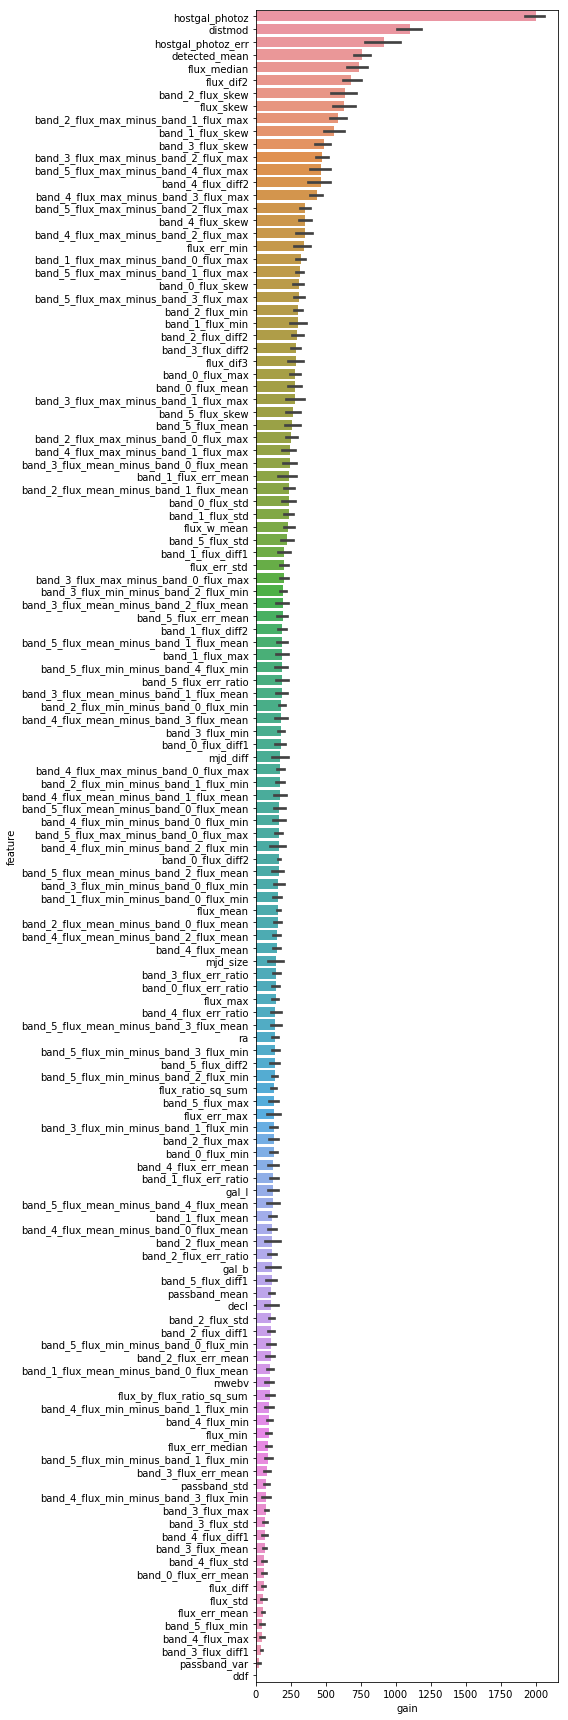

In [23]:
gc.enable()
create_logger()
try:
    main()
except Exception:
    get_logger().exception('Unexpected Exception Occured')
    raise